In [1]:
import sys
from pathlib import Path

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
BASE_DIR = Path("..")
sys.path.append(str(BASE_DIR.resolve()))

# Create Data Processing Pipeline

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
x_train, _, y_train, _ = train_test_split(
    x_train, y_train,
    stratify = y_train, test_size = 0.90,random_state = SEED)

## Data pre-processing

In [7]:
INPUT_SHAPE = x_train.shape[1:]
NUM_CLASSES = 10
BATCH_SIZE = 32

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

2022-06-28 00:15:19.969535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 00:15:19.975700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 00:15:19.976214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-28 00:15:19.977314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
def get_transform_func(num_classes) -> callable:
    """
        Get function for data transformation.

        args:
            num_classes: int - Number of classes.
        returns:
            transform_data: callable - Data transformation function.
    """

    def transform_data(image: tf.Tensor, label: tf.Tensor):
        """
            Transforms image and label_data for contrastive learning.
                1) Convert image to 0-1 range.
                2) Apply random augmentations.
                3) Return augmented and unaugmented images.
                4) One hot encode labels

            args:
                image: tf.Tensor - Input image.
                label: tf.Tensor - Input label.
            returns:
                output_payload: transform_return_type - processed original image, 
                    augmented image, processed original label
        """

        # preprocess image and label
        image = tf.cast(image, tf.float32) / 255.
        label = tf.one_hot(label, num_classes)

        return image, tf.squeeze(label)

    return transform_data

In [10]:
transform_func = get_transform_func(NUM_CLASSES)

In [11]:
# create train dataset
train_data = train_data.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1024)
train_data = train_data.batch(BATCH_SIZE, drop_remainder = True)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [12]:
# create test dataset
test_data = test_data.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE, drop_remainder = True)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Create Model

In [13]:
class AlexNetCustom(tf.keras.Model):
    def __init__(self,
                 input_shape,
                 num_classes,
                 name = None):
        super(AlexNetCustom, self).__init__(name = name)
        self._input_shape = input_shape
        self._num_classes = num_classes

        self._conv1 = tf.keras.layers.Conv2D(
            96, 11, 2, 'same', name = 'bbone_conv1')
        self._conv2 = tf.keras.layers.Conv2D(
            256, 5, 1, 'same', name = 'bbone_conv2')
        self._conv3 = tf.keras.layers.Conv2D(
            384, 3, 2, 'same', name = 'bbone_conv3')
        self._conv4 = tf.keras.layers.Conv2D(
            384, 3, 1, 'same', name = 'bbone_conv4')
        self._conv5 = tf.keras.layers.Conv2D(
            356, 3, 1, 'same', name = 'bbone_conv5')        
        self._gpool2d = tf.keras.layers.GlobalAveragePooling2D(name = 'bbone_gpool')

        self._fc1 = tf.keras.layers.Dense(1024, name = 'fc1')
        self._fc2 = tf.keras.layers.Dense(1024, name = 'fc2')
        self._fc_out = tf.keras.layers.Dense(num_classes, name = 'fc_out')

    def call(self, x_in):
        x = self._conv1(x_in)
        x = tf.nn.relu(x, name = 'bbone_relu1')
        x = self._conv2(x)
        x = tf.nn.relu(x, name = 'bbone_relu2')
        x = self._conv3(x)
        x = tf.nn.relu(x, name = 'bbone_relu3')
        x = self._conv4(x)
        x = tf.nn.relu(x, name = 'bbone_relu4')
        x = self._conv5(x)
        x = tf.nn.relu(x, name = 'bbone_relu5')
        x = self._gpool2d(x)
        x = self._fc1(x)
        x = tf.nn.relu(x, name = 'relu6')
        x = self._fc2(x)
        x = tf.nn.relu(x, name = 'relu7')
        x = self._fc_out(x)
        x_out = tf.nn.softmax(x, name = 'softmax_out')
        
        return x_out
        

In [14]:
mbnet = AlexNetCustom(INPUT_SHAPE, NUM_CLASSES, 'alexnet_custom')
mbnet.build([None,*INPUT_SHAPE])

In [15]:
EPOCHS = 20
LEARNING_RATE = 0.00001

In [16]:
opt=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

In [17]:
mbnet.load_weights('assets/pretrain/weights/model_encoder_500.h5', by_name=True)

# Define Training Loop

In [18]:
def loss_function(y_true, y_pred):
    y_pred_clipped = tf.clip_by_value(y_pred, 0.000001, 1.0 - 0.000001)
    return tf.reduce_mean(-1.0 * tf.reduce_sum(y_true * tf.math.log(y_pred_clipped), axis = -1))

In [19]:
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = mbnet(x_batch)
        loss_value = loss_function(y_batch, y_pred)

    # grads = tape.gradient(loss_value, mbnet.trainable_variables)
    # for grad, weight in zip(grads, mbnet.trainable_variables):
    #     weight.assign_sub(LEARNING_RATE * grad)
    opt.minimize(loss_value, mbnet.trainable_variables, tape = tape)
    return loss_value


In [20]:
@tf.function
def test_step(x_batch, y_batch):
    """
        Test step wrapped in a tf Function.
    """
    y_pred = mbnet(x_batch)
    loss_value = loss_function(y_batch, y_pred)

    return loss_value

## Train

In [21]:
def train():
    """
        Train Mbnet on CIFAR10.
    """

    losses_train = []
    losses_test = []
    for epoch in range(EPOCHS):
        print(f"Working on epoch: {epoch}...")
        tf.keras.backend.set_learning_phase(1)
        for train_idx, (x_batch_train, y_batch_train) in enumerate(train_data):
            loss_value_train = train_step(x_batch_train, y_batch_train)
            losses_train.append(loss_value_train.numpy())

            if train_idx % 100 == 0:
                print(f"Loss at step {train_idx} is {loss_value_train.numpy():.2f}.")

        print(f"Finished epoch: {epoch}. Running test inference...")
        tf.keras.backend.set_learning_phase(0)
        losses_test_tmp = []
        for test_idx, (x_batch_test, y_batch_test) in enumerate(test_data):
            loss_value_test = test_step(x_batch_test, y_batch_test)
            losses_test_tmp.append(loss_value_test.numpy())
            
        losses_test.append(np.mean(losses_test_tmp))
        print(f"Test set loss: {np.mean(losses_test_tmp):.2f}.")

    return losses_train, losses_test


# train and plot loss
train_losses, test_losses = train()

Working on epoch: 0...


/home/mikheil/.conda/envs/py39-tf280/lib/python3.9/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-06-28 00:15:21.767207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


Loss at step 0 is 2.30.
Loss at step 100 is 2.05.
Finished epoch: 0. Running test inference...
Test set loss: 1.92.
Working on epoch: 1...
Loss at step 0 is 1.87.
Loss at step 100 is 1.62.
Finished epoch: 1. Running test inference...
Test set loss: 1.79.
Working on epoch: 2...
Loss at step 0 is 1.90.
Loss at step 100 is 1.69.
Finished epoch: 2. Running test inference...
Test set loss: 1.73.
Working on epoch: 3...
Loss at step 0 is 1.86.
Loss at step 100 is 1.58.
Finished epoch: 3. Running test inference...
Test set loss: 1.69.
Working on epoch: 4...
Loss at step 0 is 2.00.
Loss at step 100 is 1.32.
Finished epoch: 4. Running test inference...
Test set loss: 1.64.
Working on epoch: 5...
Loss at step 0 is 1.67.
Loss at step 100 is 1.55.
Finished epoch: 5. Running test inference...
Test set loss: 1.60.
Working on epoch: 6...
Loss at step 0 is 1.65.
Loss at step 100 is 1.72.
Finished epoch: 6. Running test inference...
Test set loss: 1.57.
Working on epoch: 7...
Loss at step 0 is 1.37.
Los

# Visualise Loss

In [22]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Loss')

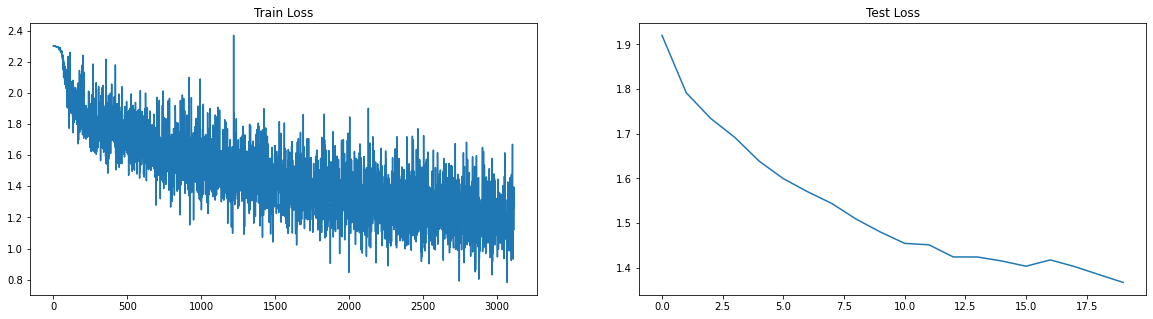

In [23]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,5))
ax0.plot(train_losses)
ax0.set_title('Train Loss')
ax1.plot(test_losses)
ax1.set_title('Test Loss')